# Author: Michael Elgin (melgin@uwyo.edu)
# 2023_11_22

# Notebook for Pipeline Optimization

## Pipeline overview

This notebook explores the following ML pipeline components:

- Feature normalization
- Feature reduction (dimensionality reduction)
- Sample reduction

Changes to these pipeline components are examined for their affect on regression and classification.

For regression, a linear model is used. (white wine only)

For classification, a decision tree is used.

### Feature normalization overview

Feature normalization, in this case, means to scale the features to their z-scores (or not).

### Feature reduction overview

Feature reduction will select the top 5 features that are most strongly positively/negatively correlated with the target (or not), discarding others.

### Sample reduction overview

Sample reduction, in this case, will be the decision of whether or not to remove outliers.

These are values that are outside the range of [Q1 - factor * IQR, Q3 + factor * IQR].

In [50]:
#Modules

#Python 3.11.2
import numpy as np #1.26.0
import pandas as pd #1.5.3
from sklearn.model_selection import GridSearchCV
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
#All regression algorithms will use the white wine dataset.
#Classification will use both colors.
df_red = pd.read_csv("data/winequality-red.csv", sep=";")
df_white = pd.read_csv("data/winequality-white.csv", sep=";")

features_red = df_red.iloc[:, :-1]
features_white = df_white.iloc[:, :-1]
target_red = df_red['quality']
target_white = df_white['quality']

df_red_no_qual = df_red.drop("quality", axis=1)
df_white_no_qual = df_white.drop("quality", axis=1)
df_red_no_qual["color"] = 0
df_white_no_qual["color"] = 1
df_all = pd.concat([df_white_no_qual, df_red_no_qual], ignore_index=True)
features_all = df_all.iloc[:, :-1]
target_all = df_all['color']

#### Exploration of feature normalization - first see the effect of normalization on the data.


In [3]:
#Normalize the data
def pipe_normalize(df, target_name=None):
    """Will return a dataframe where columns have been zscored, can specify a target name to avoid zscoring"""
    df_new = df.copy(deep=True)
    columns = df_new.columns
    if target_name in columns:
        columns = columns.drop(target_name)
    for column in columns:
        df_new[column] = stats.zscore(df_new[column])
    return df_new

In [4]:
df_white.describe() #Before

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [6]:
df_white_norm = pipe_normalize(df_white, target_name="quality")
df_white_norm.describe() #After

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4.898000e+03,4.898000e+03,4.898000e+03,4.898000e+03,4.898000e+03,4.898000e+03,4.898000e+03,4.898000e+03,4.898000e+03,4.898000e+03,4.898000e+03,4898.000000
mean,-3.481630e-16,4.497106e-16,1.160543e-17,-1.066249e-16,3.133467e-16,-1.015476e-17,-4.642174e-17,3.247201e-14,-1.183754e-15,-8.218098e-16,-3.713739e-16,5.877909
std,1.000102e+00,1.000102e+00,1.000102e+00,1.000102e+00,1.000102e+00,1.000102e+00,1.000102e+00,1.000102e+00,1.000102e+00,1.000102e+00,1.000102e+00,0.885639
min,-3.620351e+00,-1.966985e+00,-2.761743e+00,-1.141944e+00,-1.683274e+00,-1.958677e+00,-3.044230e+00,-2.313038e+00,-3.101408e+00,-2.364709e+00,-2.043297e+00,3.000000
25%,-6.575011e-01,-6.771010e-01,-5.304757e-01,-9.250474e-01,-4.473347e-01,-7.237750e-01,-7.144739e-01,-7.707066e-01,-6.508363e-01,-6.997104e-01,-8.242757e-01,5.000000
50%,-6.493106e-02,-1.809917e-01,-1.172780e-01,-2.349217e-01,-1.269060e-01,-7.692173e-02,-1.026189e-01,-9.609320e-02,-5.475133e-02,-1.739212e-01,-9.286267e-02,6.000000
75%,5.276390e-01,4.143393e-01,4.611988e-01,6.918185e-01,1.935226e-01,6.287364e-01,6.739664e-01,6.930457e-01,6.075653e-01,5.271310e-01,7.198184e-01,6.000000
max,8.705106e+00,8.153643e+00,1.095642e+01,1.171411e+01,1.374308e+01,1.491831e+01,7.098444e+00,1.503130e+01,4.184075e+00,5.171602e+00,2.995326e+00,9.000000


In [7]:
df_all.describe() #Before

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,0.753886
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,1.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,1.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,1.000000


In [8]:
df_all_norm = pipe_normalize(df_all, target_name="color")
df_all_norm.describe() #After

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color
count,6.497000e+03,6.497000e+03,6.497000e+03,6.497000e+03,6497.000000,6.497000e+03,6497.000000,6.497000e+03,6.497000e+03,6.497000e+03,6.497000e+03,6497.000000
mean,2.624754e-16,-2.449770e-16,3.499672e-17,6.999344e-17,0.000000,-8.749179e-17,0.000000,-3.560916e-15,2.738493e-15,2.099803e-16,-1.994813e-15,0.753886
std,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077,1.000077e+00,1.000077,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,0.430779
min,-2.634589e+00,-1.577330e+00,-2.192833e+00,-1.018034e+00,-1.342639,-1.663583e+00,-1.941780,-2.530192e+00,-3.100615e+00,-2.091935e+00,-2.089350e+00,0.000000
25%,-6.289329e-01,-6.661613e-01,-4.723335e-01,-7.657978e-01,-0.514799,-7.620742e-01,-0.685532,-7.859527e-01,-6.748622e-01,-6.805919e-01,-8.316152e-01,1.000000
50%,-1.660892e-01,-3.016939e-01,-5.941375e-02,-5.135612e-01,-0.257883,-8.594301e-02,0.039907,6.448888e-02,-5.287424e-02,-1.429373e-01,-1.608231e-01,1.000000
75%,3.738951e-01,3.664962e-01,4.911459e-01,5.584445e-01,0.255949,5.901882e-01,0.712265,7.648525e-01,6.313125e-01,4.619241e-01,6.776670e-01,1.000000
max,6.699425e+00,7.534354e+00,9.231281e+00,1.268682e+01,15.842187,1.456357e+01,5.737257,1.476879e+01,4.923029e+00,9.870879e+00,3.696231e+00,1.000000


#### Exploration of feature reduction

In [9]:
#Function to reduce the amount of features
def pipe_feature_reduce(df, target_name:str, amt=5):
    """Will return a dataframe with top <amt> of features based on correlation with target"""
    corr = df.corr()
    corr = corr.drop([column for column in corr.columns if column != target_name], axis=1)
    corr = corr.drop(target_name, axis=0)
    corr[target_name] = abs(corr[target_name])
    features_with_corr = [i for i in zip(corr.index, [val for val in corr[target_name]])]
    features_with_corr_sorted = sorted(features_with_corr, key=lambda x: x[1], reverse=True)
    df_new = df.copy(deep=True)
    return df_new.drop([pair[0] for pair in features_with_corr_sorted[amt:]], axis=1)

In [10]:
#See dataframes after feature reduction
features_white_feature_reduce = pipe_feature_reduce(df_white, "quality", amt=5)
features_white_feature_reduce.describe()

,volatile acidity,chlorides,total sulfur dioxide,density,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,0.278241,0.045772,138.360657,0.994027,10.514267,5.877909
std,0.100795,0.021848,42.498065,0.002991,1.230621,0.885639
min,0.080000,0.009000,9.000000,0.987110,8.000000,3.000000
25%,0.210000,0.036000,108.000000,0.991723,9.500000,5.000000
50%,0.260000,0.043000,134.000000,0.993740,10.400000,6.000000
75%,0.320000,0.050000,167.000000,0.996100,11.400000,6.000000
max,1.100000,0.346000,440.000000,1.038980,14.200000,9.000000


In [19]:
#See dataframes after feature reduction
features_all_feature_reduce = pipe_feature_reduce(df_all, "color", amt=5)
features_all_feature_reduce.describe()

,fixed acidity,volatile acidity,chlorides,total sulfur dioxide,sulphates,color
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.056034,115.744574,0.531268,0.753886
std,1.296434,0.164636,0.035034,56.521855,0.148806,0.430779
min,3.800000,0.080000,0.009000,6.000000,0.220000,0.000000
25%,6.400000,0.230000,0.038000,77.000000,0.430000,1.000000
50%,7.000000,0.290000,0.047000,118.000000,0.510000,1.000000
75%,7.700000,0.400000,0.065000,156.000000,0.600000,1.000000
max,15.900000,1.580000,0.611000,440.000000,2.000000,1.000000


#### Exploration of sample reduction

In [20]:
#Function to return a dataframe with outliers removed
def pipe_sample_reduce(df, factor=1.5):
    """
    returns a new dataframe that has any samples removed where any value in the sample was
    outside the range of [Q1 - factor * IQR, Q3 + factor * IQR]"""
    df_new = df.copy(deep=True)
    non_target_columns = df_new.iloc[:, :-1]
    Q1 = non_target_columns.quantile(0.25)
    Q3 = non_target_columns.quantile(0.75)
    IQR = Q3 - Q1
    return df_new[~((non_target_columns < (Q1 - factor * IQR)) | (non_target_columns > (Q3 + factor * IQR))).any(axis=1)]

In [21]:
#See difference in length of new dataframe to see how many outliers were removed
print(len(df_all))
print(len(pipe_sample_reduce(df_all, factor=1.5)))

6497
5024


In [22]:
#See difference in length of new dataframe to see how many outliers were removed
print(len(df_white))
print(len(pipe_sample_reduce(df_white, factor=1.5)))

4898
4015


#### Linear Regression - Create layered optimization

Since there are no hyperparams for linear regression, they will not be present.

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

#Create dataframe to store results for further analysis
df_reg_results_types = {
    "Normalized"    :   "bool",
    "FeatureAmt"    :   "int",
    "SampleReduce"  :   "bool",
    "MAPE"          :   "float",
}
df_reg_results = pd.DataFrame(columns=df_reg_results_types.keys()).astype(df_reg_results_types)

#Create the nested loops of optimization
for is_norm in [False, True]:
    for feature_amt in [amt for amt in range(1, len(df_white.columns))]:#Will test every feature subset from the 1 sole top feature to using every feature
        for is_sample_reduce in [False, True]:
            df_curr = df_white.copy(deep=True)
            train, test = train_test_split(df_curr, test_size=0.2, random_state=0) #Remember - also shuffles
            if is_norm:
                train = pipe_normalize(train)
                test = pipe_normalize(test)
            train = pipe_feature_reduce(train, target_name="quality", amt=feature_amt)
            test = pipe_feature_reduce(test, target_name="quality", amt=feature_amt)
            if is_sample_reduce:
                train = pipe_sample_reduce(train)
                #No reduction from test-set
            X_train = train.to_numpy()[:, 0:-1] #Features
            y_train = train.to_numpy()[:, -1] #Target
            X_test = test.to_numpy()[:, 0:-1] #Features
            y_test = test.to_numpy()[:, -1] #Target
            LR_model = LinearRegression()
            LR_model.fit(X_train, y_train)
            y_pred = LR_model.predict(X_test)
            mape = mean_absolute_percentage_error(y_test, y_pred) * 100
            print("normalized? {0}, features used: {1}, sample reduce? {2}, MAPE: {3:.3f}".format(is_norm, feature_amt, is_sample_reduce, mape))
            df_reg_results.loc[len(df_reg_results.index)] = [is_norm, feature_amt, is_sample_reduce, mape] 

normalized? False, features used: 1, sample reduce? False, MAPE: 12.417
normalized? False, features used: 1, sample reduce? True, MAPE: 12.417
normalized? False, features used: 2, sample reduce? False, MAPE: 12.422
normalized? False, features used: 2, sample reduce? True, MAPE: 12.422
normalized? False, features used: 3, sample reduce? False, MAPE: 13.251
normalized? False, features used: 3, sample reduce? True, MAPE: 19.545
normalized? False, features used: 4, sample reduce? False, MAPE: 3990.602
normalized? False, features used: 4, sample reduce? True, MAPE: 10920.327
normalized? False, features used: 5, sample reduce? False, MAPE: 11.907
normalized? False, features used: 5, sample reduce? True, MAPE: 11.930
normalized? False, features used: 6, sample reduce? False, MAPE: 11.840
normalized? False, features used: 6, sample reduce? True, MAPE: 11.879
normalized? False, features used: 7, sample reduce? False, MAPE: 5277.628
normalized? False, features used: 7, sample reduce? True, MAPE:

In [48]:
#See the results dataframe
df_reg_results.head()

,Normalized,FeatureAmt,SampleReduce,MAPE
0,False,1,False,12.417414
1,False,1,True,12.417414
2,False,2,False,12.421797
3,False,2,True,12.421588
4,False,3,False,13.250574


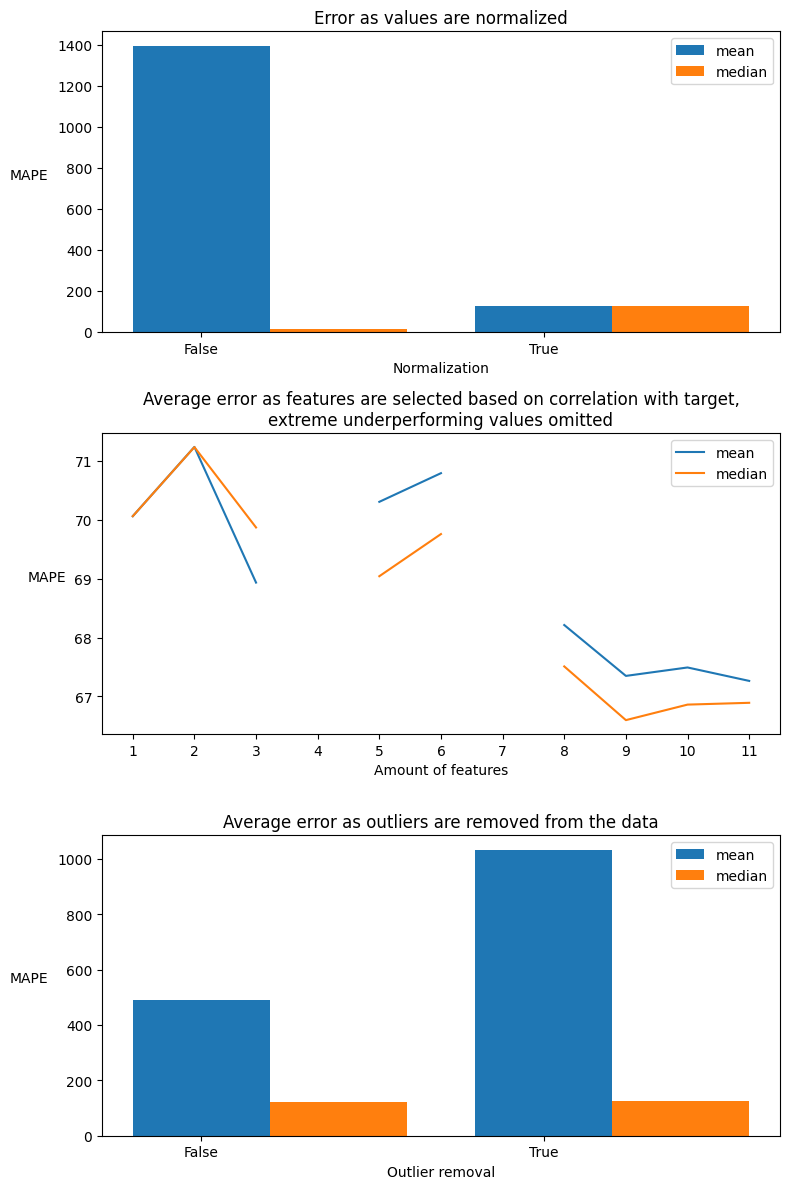

In [118]:
#Plot performance across the changes in pipeline steps.
#Normalization
normalization_bool_vals = [False, True]
normalization_mapes_mean = [df_reg_results[df_reg_results["Normalized"] == val]["MAPE"].mean() for val in normalization_bool_vals]
normalization_mapes_med = [df_reg_results[df_reg_results["Normalized"] == val]["MAPE"].median() for val in normalization_bool_vals]

#Feature reduction
feature_amt_vals = [val for val in range(1, len(df_white.columns))]
feature_amt_mapes_mean = [df_reg_results[df_reg_results["FeatureAmt"] == val]["MAPE"].mean() for val in feature_amt_vals]
feature_amt_mapes_med = [df_reg_results[df_reg_results["FeatureAmt"] == val]["MAPE"].median() for val in feature_amt_vals]

#Outlier removal from feature_amt_mapes_mean so values of interest are not squashed on the graph
outlier_threshold = 5
mape_min = min(feature_amt_mapes_mean)
feature_amt_mapes_mean = [(None if val > outlier_threshold * mape_min else val) for val in feature_amt_mapes_mean]
mape_min = min(feature_amt_mapes_med)
feature_amt_mapes_med = [(None if val > outlier_threshold * mape_min else val) for val in feature_amt_mapes_med]

#Sample reduction (outlier removal)
sample_bool_vals = [False, True]
sample_mapes_mean = [df_reg_results[df_reg_results["SampleReduce"] == val]["MAPE"].mean() for val in sample_bool_vals]
sample_mapes_med = [df_reg_results[df_reg_results["SampleReduce"] == val]["MAPE"].median() for val in sample_bool_vals]

fig, axs = plt.subplots(3, 1, figsize=(8,12))

bar_width = 0.4
axs[0].bar(np.array([0 if val == False else 1 for val in normalization_bool_vals]), normalization_mapes_mean, width=bar_width, label="mean")
axs[0].bar(np.array([0 if val == False else 1 for val in normalization_bool_vals]) + bar_width, normalization_mapes_med, width=bar_width, label="median")
axs[0].set_xticks(normalization_bool_vals, ["False" if val == False else "True" for val in normalization_bool_vals])
axs[0].set_title("Error as values are normalized")
axs[0].set_xlabel("Normalization")
axs[0].legend()

axs[1].plot(feature_amt_vals, feature_amt_mapes_mean, label="mean")
axs[1].plot(feature_amt_vals, feature_amt_mapes_med, label="median")
axs[1].set_xticks(feature_amt_vals)
axs[1].set_title("Average error as features are selected based on correlation with target,\nextreme underperforming values omitted")
axs[1].set_xlabel("Amount of features")
axs[1].legend()

axs[2].bar(np.array([0 if val == False else 1 for val in sample_bool_vals]), sample_mapes_mean, width=bar_width, label="mean")
axs[2].bar(np.array([0 if val == False else 1 for val in sample_bool_vals]) + bar_width, sample_mapes_med, width=bar_width, label="median")
axs[2].set_xticks(sample_bool_vals, ["False" if val == False else "True" for val in normalization_bool_vals])
axs[2].set_title("Average error as outliers are removed from the data")
axs[2].set_xlabel("Outlier removal")
axs[2].legend()

for ax in range(3):
    axs[ax].set_ylabel("MAPE", rotation=0, labelpad=20)

plt.tight_layout()

plt.savefig("regression_performance")

#### Decision Tree Classification - Create layered optimization

This will tune hyperparameters at the same time, and make use of nested resampling

In [121]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold #Allows a setup of nested resampling

#Hyperparams - exponential grid-search
hp_list_max_depth_exponents_DTC = [i for i in range(0,7)]
hp_list_max_depth_DTC = [2**i for i in hp_list_max_depth_exponents_DTC]

hp_list_min_samples_split_exponents_DTC = [i for i in range(1, 15)]
hp_list_min_samples_split_DTC = [2**i for i in hp_list_min_samples_split_exponents_DTC]

params_inputs_DTC = {
    'max_depth' : hp_list_max_depth_DTC,
    'min_samples_split' : hp_list_min_samples_split_DTC,
}

#Create dataframe to store results for further analysis
df_cls_results_types = {
    "Normalized"    :   "bool",
    "FeatureAmt"    :   "int",
    "SampleReduce"  :   "bool",
    "TreeMaxDepth"  :   "int",
    "TreeMinSamplesSplit"   :   "int",
    "TreeAccuracy"  :   "float",
    "ForestMaxDepth"    :   "int",
    "ForestMinSamplesSplit"   :   "int",
    "ForestAccuracy"  :   "float",
}
df_cls_results = pd.DataFrame(columns=df_cls_results_types.keys()).astype(df_cls_results_types)

#Create the nested loops of optimization
for is_norm in [False, True]:
    for feature_amt in [amt for amt in range(1, len(df_white.columns))]:#Will test every feature subset from the 1 sole top feature to using every feature
        for is_sample_reduce in [False, True]:
            df_curr = df_all.copy(deep=True)
            if is_norm:
                df_curr = pipe_normalize(df_curr, target_name="color")
            df_curr = pipe_feature_reduce(df_curr, target_name="color", amt=feature_amt)
            if is_sample_reduce:
                df_curr = pipe_sample_reduce(df_curr)
            features_curr = df_curr.iloc[:, :-1]
            target_curr = df_curr['color']
            DTC = DecisionTreeClassifier(random_state=0)
            GS = GridSearchCV(DTC, params_inputs_DTC, scoring='accuracy')
            outer_cv = KFold(n_splits = 3, shuffle=True, random_state=0)
            outer_scores = cross_val_score(GS, features_curr.to_numpy(), target_curr.to_numpy(), cv=outer_cv)
            GS.fit(features_curr.to_numpy(), target_curr.to_numpy())
            best_max_depth_tree = GS.best_params_["max_depth"]
            best_min_samples_split_tree = GS.best_params_["min_samples_split"]
            acc_tree = outer_scores.mean()
            print("normalized? {0}, features used: {1}, sample reduce? {2}, max depth: {4}, min samples for split: {5}, unbiased accuracy estimate: {3:.3f}"\
                .format(is_norm, feature_amt, is_sample_reduce, acc_tree, best_max_depth_tree, best_min_samples_split_tree))
            df_cls_results.loc[len(df_cls_results.index)] = [
                is_norm,
                feature_amt,
                is_sample_reduce,
                best_max_depth_tree,
                best_min_samples_split_tree,
                acc_tree,
                0,
                0,
                0.0,
            ]

normalized? False, features used: 1, sample reduce? False, max depth: 8, min samples for split: 64, unbiased accuracy estimate: 0.925
normalized? False, features used: 1, sample reduce? True, max depth: 8, min samples for split: 64, unbiased accuracy estimate: 0.924


KeyboardInterrupt: 